In [1]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Charger les données à partir d'un fichier CSV (remplacer par le chemin du fichier si nécessaire)
df = pd.read_csv('C:/Users/Hiba/Desktop/S7/Deep learning/trading/nifty50.csv', low_memory=False)

# Convertir la colonne 'Date' en format datetime pour une manipulation facile
df['Date'] = pd.to_datetime(df['Date'])

# Sélectionner les colonnes pertinentes pour l'analyse
df = df[['Date', 'Open', 'High', 'Low', 'Close']]

# Remplir les valeurs manquantes en utilisant la méthode de forward fill
df.fillna(method='ffill', inplace=True)

# Normaliser les données pour que les valeurs soient entre 0 et 1
scaler = MinMaxScaler(feature_range=(0, 1))
df[['Open', 'High', 'Low', 'Close']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close']])

# Afficher les premières lignes pour vérifier les données prétraitées
print(df.head())

        Date      Open      High       Low     Close
0 2007-11-27  0.022805  0.031080  0.023460  0.029031
1 2007-11-28  0.029214  0.029287  0.026664  0.026931
2 2007-11-29  0.026968  0.027039  0.025647  0.026635
3 2007-11-30  0.026399  0.028331  0.027157  0.027772
4 2007-12-03  0.027889  0.029437  0.028143  0.029226


C:\Users\Hiba\AppData\Local\Temp\ipykernel_13864\2704438612.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [5]:
# Fonction pour créer 4000 histogrammes 2D pour une variable donnée
def create_4000_histograms(data, column_name, bin_size=20, num_histograms=4000):
    histograms = []
    for i in range(50, 50 + num_histograms):
        x_values = data[column_name].iloc[i-50:i-1].values
        y_values = data[column_name].iloc[i-49:i].values
        hist, xedges, yedges = np.histogram2d(x_values, y_values, bins=bin_size)
        histograms.append(hist)
    return histograms

In [7]:
# Créer les histogrammes pour toutes les colonnes: 'Open', 'High', 'Low', 'Close'
columns = ['Open', 'High', 'Low', 'Close']
histograms_dict = {}
for column in columns:
    histograms_dict[column] = create_4000_histograms(df, column)

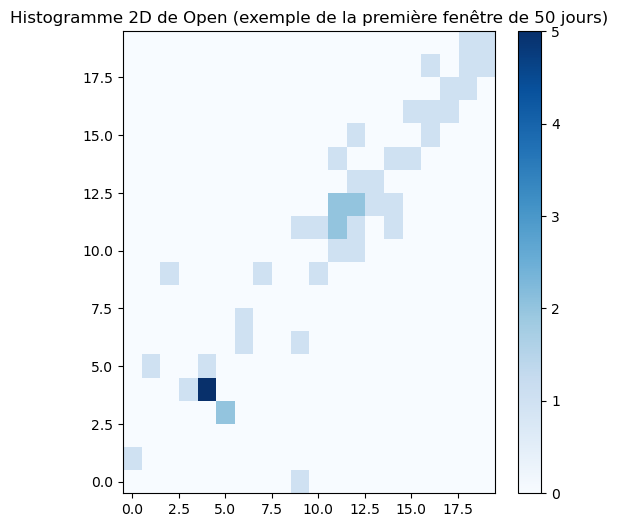

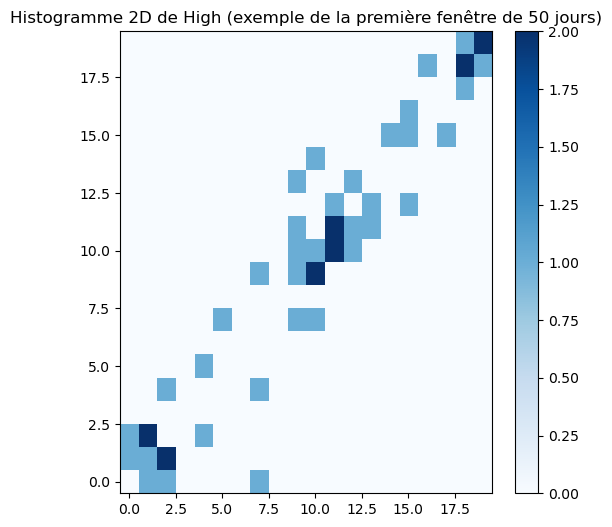

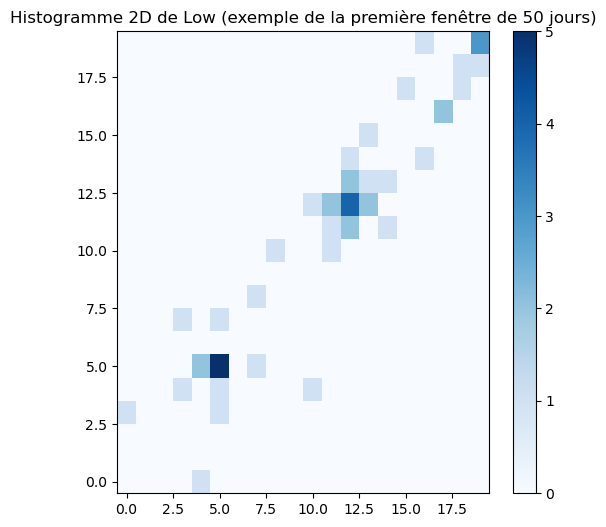

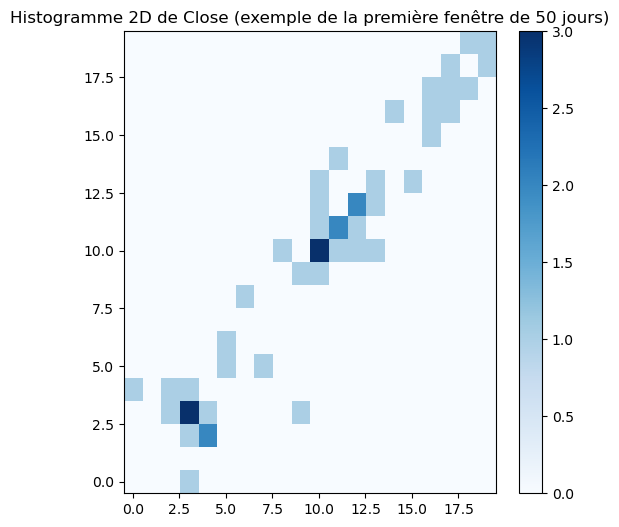

In [8]:
# Afficher un histogramme 2D pour chaque colonne
for column in columns:
    plt.figure(figsize=(6, 6))
    plt.imshow(histograms_dict[column][0].T, origin='lower', aspect='auto', cmap='Blues')
    plt.colorbar()
    plt.title(f'Histogramme 2D de {column} (exemple de la première fenêtre de 50 jours)')
    plt.show()

In [11]:
# Afficher le nombre d'histogrammes générés pour chaque colonne
for column in columns:
    print(f"Nombre d'histogrammes générés pour {column} : {len(histograms_dict[column])}")

Nombre d'histogrammes générés pour Open : 4000
Nombre d'histogrammes générés pour High : 4000
Nombre d'histogrammes générés pour Low : 4000
Nombre d'histogrammes générés pour Close : 4000


In [13]:
# Fonction pour préparer les données pour le CNN (matrices 2D et labels)
def prepare_data_for_cnn(histograms_dict, df, target_column, seq_length=50, bin_size=20):
    X = []
    y = []
    num_histograms = len(histograms_dict[target_column])
    for i in range(num_histograms - 1):
        X.append(histograms_dict[target_column][i])
        y.append(df[target_column].iloc[i + seq_length])
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)  # Reshape en une matrice colonne
    return X, y

In [15]:
# Préparer les données pour toutes les colonnes cibles et les diviser en ensembles
columns = ['Open', 'High', 'Low', 'Close']
data_splits = {}
for target_column in columns:
    X, y = prepare_data_for_cnn(histograms_dict, df, target_column)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
    data_splits[target_column] = {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test
    }
    print(f"Shape des données d'entraînement pour {target_column} : {X_train.shape}")
    print(f"Shape des données de validation pour {target_column} : {X_val.shape}")
    print(f"Shape des données de test pour {target_column} : {X_test.shape}")

Shape des données d'entraînement pour Open : (2799, 20, 20)
Shape des données de validation pour Open : (600, 20, 20)
Shape des données de test pour Open : (600, 20, 20)
Shape des données d'entraînement pour High : (2799, 20, 20)
Shape des données de validation pour High : (600, 20, 20)
Shape des données de test pour High : (600, 20, 20)
Shape des données d'entraînement pour Low : (2799, 20, 20)
Shape des données de validation pour Low : (600, 20, 20)
Shape des données de test pour Low : (600, 20, 20)
Shape des données d'entraînement pour Close : (2799, 20, 20)
Shape des données de validation pour Close : (600, 20, 20)
Shape des données de test pour Close : (600, 20, 20)


In [17]:
# Exemple : accéder aux données pour une colonne spécifique, par exemple 'Open'
X_train_open = data_splits['Open']['X_train']
y_train_open = data_splits['Open']['y_train']
print(f"Exemple : Shape des données d'entraînement pour 'Open' : {X_train_open.shape}")

Exemple : Shape des données d'entraînement pour 'Open' : (2799, 20, 20)


In [19]:
# Initialisation des paramètres pour les couches de convolution
class ConvLayer:
    def __init__(self, input_channels, output_channels, kernel_size, stride=1, activation=None):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.activation = activation
        # Correct weight initialization to match input shape
        self.weights = np.random.randn(output_channels, input_channels, kernel_size, kernel_size) * 0.01
        self.bias = np.zeros(output_channels)

    def forward(self, x):
        self.input = x
        batch_size, height, width, in_channels = x.shape
        # Verify input channels match weight shape
        assert in_channels == self.input_channels, f"Input channels {in_channels} doesn't match expected {self.input_channels}"
        
        out_height = (height - self.kernel_size) // self.stride + 1
        out_width = (width - self.kernel_size) // self.stride + 1
        output = np.zeros((batch_size, out_height, out_width, self.output_channels))
        
        for b in range(batch_size):
            for i in range(out_height):
                for j in range(out_width):
                    for k in range(self.output_channels):
                        # Extract the current patch
                        patch = x[b, 
                                i*self.stride:i*self.stride+self.kernel_size, 
                                j*self.stride:j*self.stride+self.kernel_size, 
                                :] # Shape: (kernel_size, kernel_size, input_channels)
                        # Reshape weights for this output channel
                        weight = self.weights[k] # Shape: (input_channels, kernel_size, kernel_size)
                        # Compute convolution for this patch
                        output[b, i, j, k] = np.sum(patch * weight.transpose(1, 2, 0)) + self.bias[k]

        if self.activation == 'relu':
            return np.maximum(0, output)
        return output

    def backward(self, grad_output):
        batch_size, out_height, out_width, _ = grad_output.shape
        grad_input = np.zeros_like(self.input)
        grad_weights = np.zeros_like(self.weights)
        grad_bias = np.sum(grad_output, axis=(0, 1, 2))

        for b in range(batch_size):
            for i in range(out_height):
                for j in range(out_width):
                    for k in range(self.output_channels):
                        patch = self.input[b,
                                         i*self.stride:i*self.stride+self.kernel_size,
                                         j*self.stride:j*self.stride+self.kernel_size,
                                         :]
                        grad_weights[k] += patch.transpose(2, 0, 1) * grad_output[b, i, j, k]
                        grad_input[b,
                                 i*self.stride:i*self.stride+self.kernel_size,
                                 j*self.stride:j*self.stride+self.kernel_size,
                                 :] += (self.weights[k].transpose(1, 2, 0) * grad_output[b, i, j, k])

        return grad_input, grad_weights, grad_bias

In [21]:
# Initialisation des paramètres pour les couches de pooling
class MaxPoolLayer:
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride
        self.cache = None

    def forward(self, input_tensor):
        self.input = input_tensor
        batch_size, height, width, channels = input_tensor.shape
        pool_height, pool_width = self.pool_size, self.pool_size
        output_height = (height - pool_height) // self.stride + 1
        output_width = (width - pool_width) // self.stride + 1
        output_tensor = np.zeros((batch_size, output_height, output_width, channels))
        self.max_indices = {}
        
        for b in range(batch_size):
            for c in range(channels):
                for i in range(output_height):
                    for j in range(output_width):
                        h_start = i * self.stride
                        w_start = j * self.stride
                        region = input_tensor[b, h_start:h_start+pool_height, w_start:w_start+pool_width, c]
                        max_val = np.max(region)
                        output_tensor[b, i, j, c] = max_val
                        max_pos = np.unravel_index(np.argmax(region), region.shape)
                        self.max_indices[(b, i, j, c)] = (h_start + max_pos[0], w_start + max_pos[1])
        
        return output_tensor

    def backward(self, grad_output):
        batch_size, height, width, channels = self.input.shape
        pool_height, pool_width = self.pool_size, self.pool_size
        grad_input = np.zeros_like(self.input)
        
        output_height = grad_output.shape[1]
        output_width = grad_output.shape[2]
        
        for b in range(batch_size):
            for c in range(channels):
                for i in range(output_height):
                    for j in range(output_width):
                        h, w = self.max_indices[(b, i, j, c)]
                        grad_input[b, h, w, c] += grad_output[b, i, j, c]
        
        return grad_input

In [23]:
# Initialisation des paramètres pour les couches fully connected
class DenseLayer:
    def __init__(self, input_size, output_size, activation):
        self.weights = np.random.randn(input_size, output_size) * 0.1
        self.bias = np.zeros(output_size)
        self.activation = activation
        self.input = None
        self.output = None

    def forward(self, input_tensor):
        self.input = input_tensor
        output = np.dot(input_tensor, self.weights) + self.bias

        if self.activation == 'relu':
            output = np.maximum(0, output)

        self.output = output
        return output

    def backward(self, grad_output):
        # Calcul du gradient par rapport aux poids
        grad_weights = np.dot(self.input.T, grad_output)

        # Calcul du gradient par rapport au biais
        grad_bias = np.sum(grad_output, axis=0)

        # Calcul du gradient pour la couche précédente
        grad_input = np.dot(grad_output, self.weights.T)

        return grad_input, grad_weights, grad_bias

In [25]:
# Backpropagation et optimisation Adamclass AdamOptimizer:
class AdamOptimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, model, grads):
        """
        model: dict of layer objects, e.g. {'conv1': conv1, 'fc1': fc1, ...}
        grads: dict of gradients keyed by strings, e.g. {'conv1.weights': np.array, 'conv1.bias': np.array, ...}
        """
        self.t += 1
        for param_key, grad in grads.items():
            # param_key is something like "conv1.weights" or "fc2.bias"
            if param_key not in self.m:
                # Initialize moment vectors
                self.m[param_key] = np.zeros_like(grad)
                self.v[param_key] = np.zeros_like(grad)

            # Adam moment estimates
            self.m[param_key] = 0.9 * self.m[param_key] + 0.1 * grad
            self.v[param_key] = 0.999 * self.v[param_key] + 0.001 * (grad ** 2)

            m_hat = self.m[param_key] / (1 - 0.9 ** self.t)
            v_hat = self.v[param_key] / (1 - 0.999 ** self.t)

            # Parse "conv1.weights" -> layer_name = "conv1", param_type = "weights"
            layer_name, param_type = param_key.split('.')

            # Retrieve the actual layer object from the model
            layer = model[layer_name]

            # Apply the update to the correct array
            if param_type == 'weights':
                layer.weights -= self.learning_rate * m_hat / (np.sqrt(v_hat) + 1e-8)
            else:
                # param_type == 'bias'
                layer.bias -= self.learning_rate * m_hat / (np.sqrt(v_hat) + 1e-8)

In [27]:
# Fonction de calcul de l'accuracy avec une marge
def calculate_accuracy(y_true, y_pred, margin=0.8):
    accuracy = np.mean(np.abs(y_true - y_pred) <= margin)
    return accuracy

In [29]:
# Fonction de construction du modèle CNN personnalisé
def build_cnn(input_shape):
    input_channels = input_shape[-1]  # Get number of input channels from input shape
    conv1 = ConvLayer(input_channels=input_channels, output_channels=32, kernel_size=3, stride=1, activation='relu')
    pool1 = MaxPoolLayer(pool_size=2, stride=2)
    conv2 = ConvLayer(input_channels=32, output_channels=64, kernel_size=3, stride=1, activation='relu')
    pool2 = MaxPoolLayer(pool_size=2, stride=2)
    conv3 = ConvLayer(input_channels=64, output_channels=128, kernel_size=3, stride=1, activation='relu')
    
    # Calculate the output dimensions after convolutions and pooling
    height, width, _ = input_shape[1:]
    output_height = ((((height - 3) + 1) // 2 - 3) + 1) // 2 - 3 + 1
    output_width = ((((width - 3) + 1) // 2 - 3) + 1) // 2 - 3 + 1
    flattened_size = output_height * output_width * 128
    
    fc1 = DenseLayer(input_size=flattened_size, output_size=64, activation='relu')
    fc2 = DenseLayer(input_size=64, output_size=1, activation='linear')
    
    return {
        'conv1': conv1,
        'pool1': pool1,
        'conv2': conv2,
        'pool2': pool2,
        'conv3': conv3,
        'fc1': fc1,
        'fc2': fc2
    }

In [31]:
# Fonction de forward pass dans le réseau
def forward_pass(model, X):
    x = model['conv1'].forward(X)
    x = model['pool1'].forward(x)
    x = model['conv2'].forward(x)
    x = model['pool2'].forward(x)
    x = model['conv3'].forward(x)
    batch_size, height, width, channels = x.shape
    x = x.reshape(batch_size, -1)
    print(f"Shape after flattening: {x.shape}")  # Should be (batch_size, 128)
    x = model['fc1'].forward(x)
    print(f"Shape after fc1: {x.shape}")  # Should be (batch_size, 64)
    x = model['fc2'].forward(x)
    print(f"Shape after fc2: {x.shape}")  # Should be (batch_size, 1)
    return x

In [33]:
# Fonction de backward pass (rétropropagation) pour les convolutions
def backward_pass(model, X, grad_output):
    # Backprop through fc2
    grad_input_fc2, grad_weights_fc2, grad_bias_fc2 = model['fc2'].backward(grad_output)
    # Backprop through fc1
    grad_input_fc1, grad_weights_fc1, grad_bias_fc1 = model['fc1'].backward(grad_input_fc2)
    grad_input_fc1_reshaped = grad_input_fc1.reshape(X.shape[0], 1, 1, 128)
    # Backprop through conv3
    grad_conv3, grad_weights_conv3, grad_bias_conv3 = model['conv3'].backward(grad_input_fc1_reshaped)
    # Backprop through pool2
    grad_pool2 = model['pool2'].backward(grad_conv3)
    # Backprop through conv2
    grad_conv2, grad_weights_conv2, grad_bias_conv2 = model['conv2'].backward(grad_pool2)
    # Backprop through pool1
    grad_pool1 = model['pool1'].backward(grad_conv2)
    # Backprop through conv1
    grad_conv1, grad_weights_conv1, grad_bias_conv1 = model['conv1'].backward(grad_pool1)

    # Return a dictionary keyed by "<layer_name>.<param_type>"
    return {
        'conv1.weights': grad_weights_conv1,
        'conv1.bias':    grad_bias_conv1,
        'conv2.weights': grad_weights_conv2,
        'conv2.bias':    grad_bias_conv2,
        'conv3.weights': grad_weights_conv3,
        'conv3.bias':    grad_bias_conv3,
        'fc1.weights':   grad_weights_fc1,
        'fc1.bias':      grad_bias_fc1,
        'fc2.weights':   grad_weights_fc2,
        'fc2.bias':      grad_bias_fc2,
    }

In [35]:
# Fonction d'entraînement corrigée
def train_model(model, X_train, y_train, X_val, y_val, epochs=150, learning_rate=0.001, margin=0.08):
    optimizer = AdamOptimizer(learning_rate=learning_rate)
    
    def mean_squared_error(y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    for epoch in range(epochs):
        # 1) Forward pass on training set
        y_pred_train = forward_pass(model, X_train)
        
        # 2) Compute loss & accuracy for training
        loss_train = mean_squared_error(y_train, y_pred_train)
        accuracy_train = calculate_accuracy(y_train, y_pred_train, margin)
        
        # 3) Backward pass on training set
        grad_output_train = (y_pred_train - y_train)
        grads = backward_pass(model, X_train, grad_output_train)  # returns dict with "conv1.weights", etc.
        
        # 4) Update model parameters
        optimizer.update(model, grads)
        
        # (Optional) Forward pass on validation set for metrics
        y_pred_val = forward_pass(model, X_val)
        loss_val = mean_squared_error(y_val, y_pred_val)
        accuracy_val = calculate_accuracy(y_val, y_pred_val, margin)
        
        print(f"Epoch {epoch+1}/{epochs} - Accuracy (Train): {accuracy_train:.4f}, Accuracy (Val): {accuracy_val:.4f}")
        print(f"Loss (Train): {loss_train:.4f}, Loss (Val): {loss_val:.4f}")

In [ ]:
# Entraînement du modèle pour chaque colonne cible
target_columns = ['Open', 'High', 'Low', 'Close']
accuracies = {'Open': [], 'High': [], 'Low': [], 'Close': []}
for target_column in target_columns:
    print(f"Entraînement du modèle pour {target_column}...")
    X, y = prepare_data_for_cnn(histograms_dict, df, target_column)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
    X_train = X_train.reshape((-1, 20, 20, 1))
    X_val = X_val.reshape((-1, 20, 20, 1))
    X_test = X_test.reshape((-1, 20, 20, 1))
    model = build_cnn(X_train.shape)
    train_model(model, X_train, y_train, X_val, y_val, epochs=150, learning_rate=0.001, margin=0.08)
    y_pred = forward_pass(model, X_test)
    accuracy = calculate_accuracy(y_test, y_pred, margin=0.08)
    accuracies[target_column].append(accuracy)